In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline , interp1d
from scipy.optimize import curve_fit
from heapq import nsmallest
from scipy.interpolate import LSQUnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import integrate

# Lectura de datos

In [2]:
#Configuraciones iniciales
FILE = 'zetaAur-eclipse_B_2019_11_15_23_52_17.dat'
LMIN = 3931.66
LMAX = 3935.66
LLIN = 3933.66
RANG = 0.2
NSPL = 200

In [3]:
#importar datos
Data = pd.read_csv(FILE, delimiter = ' ', header = None)
Data.columns = ['L','I', 'C']
Data['L'] = Data['L']*10 #unidades en Amstrong

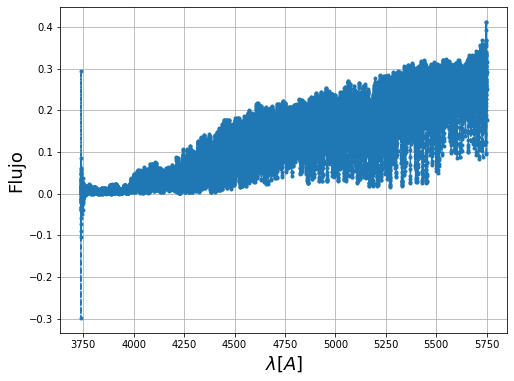

In [4]:
#Graficamos todo el ezspectro en la banda del azul
plt.figure(figsize = [8,6])
plt.plot(Data['L'],Data['I'],marker='.', ls='--')
plt.grid()
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [5]:
#Recortamos en el rango de la línea K
New_Data = Data[(Data['L'] >= LMIN) & (Data['L'] <= LMAX)] #Se encuentran los valores cercanos a la config inicial
New_Data.index = list(range(len(New_Data)))
L_min = New_Data['L'].min()
L_max = New_Data['L'].max()

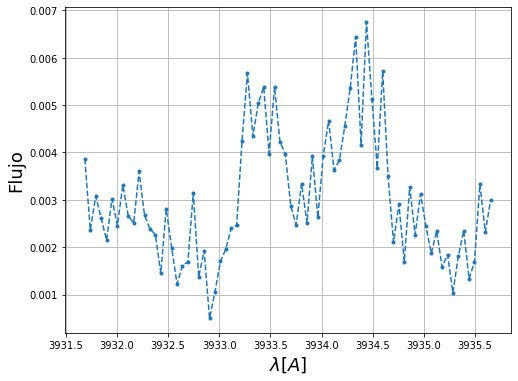

In [6]:
#Graficamos los datos del segmento de la línea K
plt.figure(figsize = [8,6])
plt.plot(New_Data['L'],New_Data['I'],marker='.', ls='--')
plt.grid()
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
plt.show()

# Ajuste del espectro usando Splines

In [7]:
def ReductorDatos(lamnda, Intensidad,start,end,paso):
    
    List_pasos = np.arange(start,end, paso)
    Datos_agrupados = {}
    Datos_agrupados['L'] = []
    Datos_agrupados['I'] = []
    for i in range(1,len(List_pasos)):
        Agrup_lamnda = lamnda[(lamnda >= List_pasos[i-1]) & (lamnda < List_pasos[i])]
        
        Datos_agrupados['L'].append(Agrup_lamnda)
        Datos_agrupados['I'].append(Intensidad[  Agrup_lamnda.index  ]) # Agrup_lamnda.index  obtiene la llave compartida
    return Datos_agrupados

In [17]:
(3931.6-3935.6)/200

-0.02

In [24]:
ajustedatos = ReductorDatos(New_Data['L'], New_Data['I'],3931.6,3935.6,0.02)

In [25]:
newdatosL = [] 
newdatosI = []
for i in range(len(ajustedatos['I'])):
    newdatosL.append(ajustedatos['L'][i].median())
    newdatosI.append(ajustedatos['I'][i].median())
    datosajustI = [x for x in newdatosI if str(x) != 'nan']
    datosajustL = [x for x in newdatosL if str(x) != 'nan']
cs = InterpolatedUnivariateSpline(datosajustL,datosajustI)
xs =  np.linspace(L_min,  L_max, 100)

In [26]:
print(cs(xs))

[0.00386315 0.00235731 0.0027332  0.00309055 0.00259951 0.00210428
 0.00267831 0.00291168 0.00246356 0.00317974 0.00309417 0.00243156
 0.00257948 0.00351576 0.00317934 0.00244401 0.00240594 0.00236826
 0.00158305 0.00187074 0.00284892 0.00216715 0.00133867 0.00135884
 0.00159904 0.00158986 0.00290102 0.00251297 0.00132877 0.00193203
 0.00094472 0.00049654 0.00124302 0.00168475 0.00186325 0.00221071
 0.00238948 0.002447   0.00366066 0.00528397 0.00544807 0.00433121
 0.00474312 0.00552442 0.00493228 0.00398963 0.00518904 0.00490391
 0.00404442 0.00392527 0.00308801 0.00240106 0.00283427 0.00329244
 0.0025019  0.00349032 0.00356952 0.00261647 0.00371797 0.00467424
 0.00429521 0.00355022 0.00378191 0.00435966 0.00479562 0.00571717
 0.00649886 0.00451242 0.00521158 0.00684945 0.00517418 0.0036165
 0.0048024  0.0055244  0.00343275 0.00211156 0.00266272 0.00256268
 0.00172137 0.00308806 0.0027529  0.00239331 0.00315219 0.00261704
 0.00192142 0.00207134 0.00228829 0.00162828 0.00179136 0.00153

In [27]:
datosajust = pd.DataFrame({'L': datosajustL, 'I': datosajustI})

In [22]:
#Falta hacer bien el ajuste, por el momento tomo los datos del código de C++
Data_s = pd.read_csv('HIEW_Spline.txt', delimiter = ' ', header = None) #Datos ajuste
Data_s.columns = ['L','I']

FileNotFoundError: [Errno 2] File b'HIEW_Spline.txt' does not exist: b'HIEW_Spline.txt'

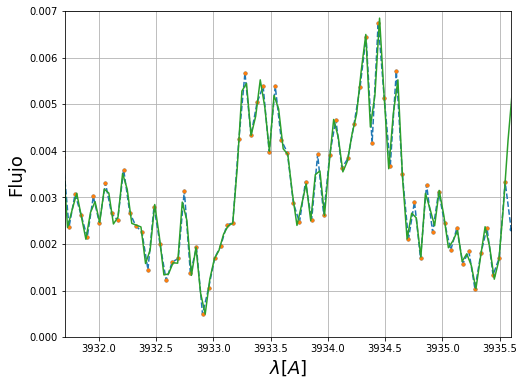

In [28]:
plt.figure(figsize = [8,6])
plt.plot(New_Data['L'],New_Data['I'],marker='.', ls='--')
#plt.plot(Data_s['L'],Data_s['I'],marker='', ls='-')
plt.plot(datosajust['L'],datosajust['I'],marker='.', ls='')
plt.plot(xs,cs(xs),marker='', ls='-')
plt.grid()
plt.ylim(0,0.007)
plt.xlim(3931.7,3935.6)
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
plt.show()

# Valores máximos, mínimos y medios de intensidad

In [87]:
#Creo dos dataFrame desde el mínimo K3 hacía la izquiera y la derecha, teniendo en cuenta un rango de ese mínimo
b = datosajust[(datosajust['L'] >= LMIN) & (datosajust['L'] <= (LLIN - RANG))]
r = datosajust[(datosajust['L'] >= (LLIN + RANG)) & (datosajust['L'] <= LMAX)]
b.index = list(range(len(b)))
r.index = list(range(len(r)))

In [88]:
#Calculo los máximos y mínimos para cada uno de los picos
k1b=b[b['I'] == b['I'].min()]
k2b=b[b['I'] == b['I'].max()]
k1r=r[r['I'] == r['I'].min()]
k2r=r[r['I'] == r['I'].max()]
#Se usa float() para poder hacer operaciones entre datos de un dataFrame
#Hago un DataFrame que va desde K1 a K2, para B y R
pico1 = b[(b['L'] >= float(k1b['L'])) & (b['L'] <= float(k2b['L']))]
pico2 = r[(r['L'] >= float(k2r['L'])) & (r['L'] <= float(k1r['L']))]
pico1.index = list(range(len(pico1)))
pico2.index = list(range(len(pico2)))
#Calculo la intensidad media entre K1 y K2 para B y R
Ibm_teo = float(k1b['I']) + (float(k2b['I']) - float(k1b['I']))/2 #Intensidad teórica media
Ibm_ajus = nsmallest(1, pico1['I'],  key = lambda x: abs(x - Ibm_teo))[0] #El más cercano en el ajuste a la intensidad media
B_m = pico1[pico1['I'] == Ibm_ajus] 

Irm_teo = float(k1r['I']) + (float(k2r['I']) - float(k1r['I']))/2
Irm_ajus = nsmallest(1, pico2['I'],  key = lambda x: abs(x - Irm_teo))[0]
R_m = pico2[pico2['I'] == Irm_ajus]

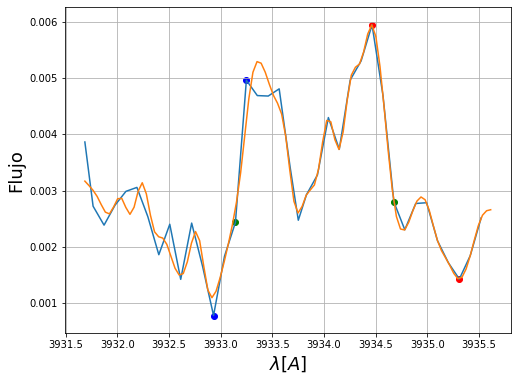

In [89]:
#Graficamos ajuste y puntos calculados anteriormente
plt.figure(figsize = [8,6])
plt.plot(datosajust['L'],datosajust['I'],marker='', ls='-')
plt.plot(Data_s['L'],Data_s['I'],marker='', ls='-')
plt.scatter(k1b['L'], k1b['I'], color = 'blue')
plt.scatter(k1r['L'], k1r['I'], color = 'r')
plt.scatter(k2b['L'], k2b['I'], color = 'blue')
plt.scatter(k2r['L'], k2r['I'], color = 'r')
plt.scatter(B_m['L'], B_m['I'], color = 'green')
plt.scatter(R_m['L'], R_m['I'], color = 'green')
plt.grid()
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
plt.show()

# Calculo del ancho equivalente

In [78]:
#Calculo de la incertidumbre de lambda para el punto medio

valor_medioB = New_Data[New_Data['L'] == nsmallest(1, New_Data['L'],  key = lambda x: abs(x - float(B_m['L'])))[0]]
indb = valor_medioB.index[0]

if float(valor_medioB['L']) < float(B_m['L']):
    Lmbinf = valor_medioB
    Lmbsup = pd.DataFrame( [[New_Data['L'][indb+1], New_Data['I'][indb+1]]], columns = ('L','I'))
else:
    Lmbsup = valor_medioB
    Lmbinf = pd.DataFrame( [[New_Data['L'][indb-1], New_Data['I'][indb-1]]], columns = ('L','I') )

valor_medioR = New_Data[New_Data['L'] == nsmallest(1, New_Data['L'],  key = lambda x: abs(x - float(R_m['L'])))[0]]
indr = valor_medioR.index[0]

if float(valor_medioR['L']) < float(R_m['L']):
    Lmrinf = valor_medioR
    Lmrsup = pd.DataFrame( [[New_Data['L'][indr+1], New_Data['I'][indr+1]]], columns = ('L','I') )
else:
    Lmrsup = valor_medioR
    Lmrinf = pd.DataFrame( [[New_Data['L'][indr-1], New_Data['I'][indr-1]]], columns = ('L','I') )

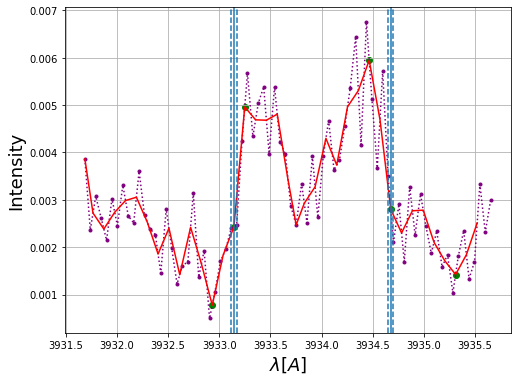

In [79]:
#Graficamos todos los calculos anteriores
plt.figure(figsize = [8,6])
plt.plot(New_Data['L'],New_Data['I'],marker='.', ls=':', color='purple') #datos
plt.plot(datosajust['L'],datosajust['I'],marker='', ls='-', color='r') #ajuste
plt.scatter(k1b['L'], k1b['I'], color='green') #Mínimo azul
plt.scatter(k1r['L'], k1r['I'], color='green') #minimo rojo
plt.scatter(k2b['L'], k2b['I'], color='green') #maximo azul
plt.scatter(k2r['L'], k2r['I'], color='green') #maximo rojo
plt.scatter(B_m['L'], B_m['I'], color='green') #punto medio azul
plt.scatter(R_m['L'], R_m['I'], color='green') #punto medio rojo

plt.axvline(float(B_m['L']), ls='-') #límite derecho del ancho de la línea
plt.axvline(float(Lmbsup['L']), ls='--') #incertudumbre izq
plt.axvline(float(Lmbinf['L']), ls='--') #incertidumbre derecha

plt.axvline(float(Lmrsup['L']), ls='--')
plt.axvline(float(R_m['L']), ls='-')
plt.axvline(float(Lmrinf['L']), ls='--')
plt.grid()
plt.ylabel("Intensity",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [80]:
W_0 = float(R_m['L']) -float(B_m['L'])
deltabm = ( float(Lmbsup['L']) - float(B_m['L']) + float(B_m['L']) - float(Lmbinf['L']))/2
deltarm = ( float(Lmrsup['L']) - float(R_m['L']) + float(R_m['L']) - float(Lmrinf['L']))/2
deltaW = np.sqrt(deltabm**2 + deltarm**2)
print("W_0 = {} +- {} [A]".format(W_0, deltaW))

W_0 = 1.5340806932103987 +- 0.037405526806261205 [A]


# Ancho equivalente

In [64]:
Data = pd.read_csv('Subtracted_spectrum_median_251119.txt', delimiter = '\t', header = 0)
Data.columns = ['L','I', 'C']
Data['L'] = Data['L']*10
Data['I'] = Data['I'] + 0.6

In [43]:
LMIN = 3931.66
LMAX = 3935.66
LLIN = 3933.66
RANG = 0.2
NSPL = 200

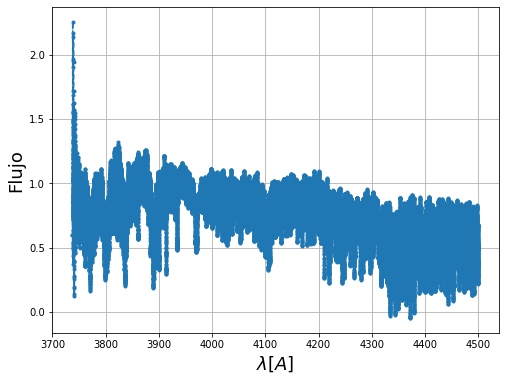

In [65]:
#Graficamos todo el ezspectro en la banda del azul
plt.figure(figsize = [8,6])
plt.plot(Data['L'],Data['I'],marker='.', ls='--')
plt.grid()
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [66]:
maximos = []
maximoss = []
for i in range(0,len(Data['I'])-1):
    if(Data['I'][i+1] > Data['I'][i] and Data['I'][i+1] > Data['I'][i + 2]):
        maximos.append(Data['I'][i+1])
promedio1 = np.mean(maximos)
for i in range(0,len(maximos)):
    if maximos[i] > promedio1:
        maximoss.append(maximos[i])
                
promedio2 = np.mean(maximoss)
print(promedio2)

1.000586159706938


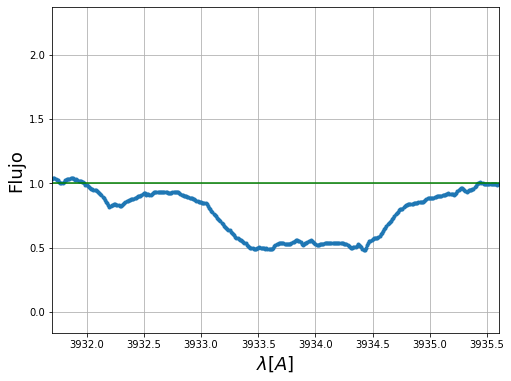

In [68]:
x = np.linspace(0,len(maximoss),len(maximoss))
plt.figure(figsize = [8,6])
plt.plot(Data['L'],Data['I'],marker='.', ls='--')
plt.axhline(promedio2, color='g')
plt.grid()
#plt.ylim(-0.6,1)
plt.xlim(3931.7,3935.6)
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [69]:
New_Data = Data[(Data['L'] >= LMIN) & (Data['L'] <= LMAX)] #Se encuentran los valores cercanos a la config inicial
New_Data.index = list(range(len(New_Data)))
L_min = New_Data['L'].min()
L_max = New_Data['L'].max()

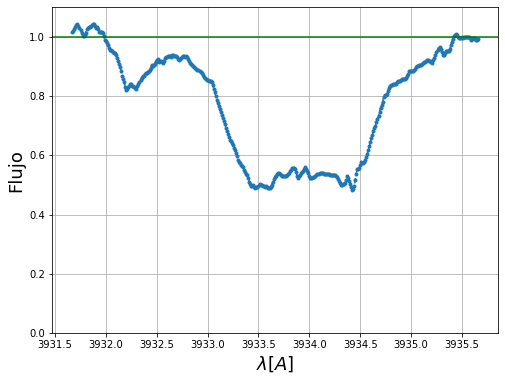

In [76]:
plt.figure(figsize = [8,6])
plt.plot(New_Data['L'],New_Data['I'],marker='.', ls='--')
plt.axhline(promedio2, color='g')
plt.grid()
plt.ylim(0,1.1)
#plt.xlim(3931.7,3935.6)
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [79]:
Aprom = promedio2*(L_max - L_min)
#aquí calcula el área hasta cero, toca hacer que lo haga entre un intervalo que se le dé

Abajo_abs = integrate.simps(New_Data['I'], New_Data['L'])
Area = Aprom - Abajo_abs
print(Area)

0.8941791899889271


In [78]:
Anchoeq = Area/promedio2
print(Anchoeq)

0.8936553652219449


In [62]:
def lista_y(datos):
    return Data['I']
integrate.quad(lista_y(New_Data['L']), promedio2, promedio2-1)

<class 'function'>


ValueError: invalid callable given

In [14]:
diff = np.diff(Data['L'])
maximos = []
flux_max = []
print(diff)
for i in range(len(diff)):
    if(diff[i] < 0.00001 and diff[i] >-0.00001):
        valor = Data['L'][i+1]

    if(valor > 0):
            maximos.append(valor)
            flux_max.append(i)
        elif(valor<0):
            pass
        maximum = maximos
        flux_maximum = flux_max

[0.01 0.01 0.01 ... 0.01 0.01 0.01]
